In [1]:
import os, sys, json
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import glob

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision import transforms

In [2]:
DEVICE_NAME = 'cuda:0'

MODEL_NAME = f'detector_2020-06-08--23-17-22'
MODEL_NAME

'detector_2020-06-08--23-17-22'

In [3]:
SEED = 1234

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
PALETTE = sns.color_palette('pastel')

In [5]:
data_path = '../data/'
preproc_val_file = os.path.join(data_path, 'preproc_val.json')
preproc_train_file = os.path.join(data_path, 'preproc_train.json')
preproc_deduplicated_train_file = os.path.join(data_path, 'preproc_deduplicated_train.json')

test_pred_boxes_file = os.path.join(data_path, 'test_pred_boxes.json')
val_pred_boxes_file = os.path.join(data_path, 'val_pred_boxes.json')
train_pred_boxes_file = os.path.join(data_path, 'train_pred_boxes.json')

In [6]:
with open(preproc_val_file) as rf:
    preproc_val = json.load(rf)
len(preproc_val)

1000

In [7]:
with open(preproc_train_file) as rf:
    preproc_train = json.load(rf)
len(preproc_train)

24632

In [8]:
with open(preproc_deduplicated_train_file) as rf:
    preproc_deduplicated_train = json.load(rf)
len(preproc_deduplicated_train)

21800

# Загружаем модель детекции

In [9]:
def get_detector_model(mask_hid_size, num_classes=2):    
    model = models.detection.maskrcnn_resnet50_fpn(
        pretrained=True, 
        progress=True,
        trainable_backbone_layers=4
    )

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.roi_heads.box_predictor = box_predictor
    
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    mask_predictor = MaskRCNNPredictor(in_features_mask, mask_hid_size, num_classes)
    model.roi_heads.mask_predictor = mask_predictor
    
    return model

In [10]:
BATCH_SIZE = 2
NUM_WORKERS = 4
HID_DIM = 256
THRESHOLD = 0.85

In [11]:
device = torch.device(DEVICE_NAME) if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [12]:
model = get_detector_model(HID_DIM)
model.to(device);

In [13]:
with open(f'models/{MODEL_NAME}.pth', "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [14]:
model.eval();

In [15]:
warnings.filterwarnings("ignore", message="The default behavior for")
warnings.filterwarnings("ignore", message="This overload of nonzero")

# Получаем предсказания детектора на валидации

In [16]:
val_files = [item['file'] for item in preproc_val]

In [17]:
to_tensor = transforms.ToTensor()

def round_box_coords(box):
    x_min, y_min, x_max, y_max = box
    x_min = max(0, int(x_min))
    y_min = max(0, int(y_min))
    x_max = int(x_max) + 1
    y_max = int(y_max) + 1
    return [ x_min, y_min, x_max, y_max]

@torch.no_grad()
def predict_boxes(model, img_names, data_path=data_path):
    results = []
    model.eval()
    for fname in tqdm(img_names, position=0, leave=True):
        fpath = os.path.join(data_path, fname)
        img = cv2.imread(fpath)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = to_tensor(img).to(device)
        
        prediction = model([img_tensor])[0]
        pred_boxes = prediction['boxes'].cpu().numpy().tolist()
        if len(pred_boxes) == 0:
            print(f'WARN: could\'n find any boxes for image {fpath}')
            results.append(dict(file=fname, boxes=[], scores=[]))
            continue
        pred_boxes = [round_box_coords(box) for box in pred_boxes]
        scores = prediction['scores'].cpu().numpy()
        sorted_pairs = sorted(zip(pred_boxes, scores), key=lambda x: x[0][0])
        pred_boxes, scores = zip(*sorted_pairs)
        results.append(dict(file=fname, boxes=pred_boxes, scores=scores))
    return results

In [18]:
def get_iou(bb1, bb2):
    # https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    b1x1, b1y1, b1x2, b1y2 = bb1
    b2x1, b2y1, b2x2, b2y2 = bb2
    
    assert b1x1 < b1x2
    assert b1y1 < b1y2
    assert b2x1 < b2x2
    assert b2y1 < b2y2

    # determine the coordinates of the intersection rectangle
    x_left = max(b1x1, b2x1)
    y_top = max(b1y1, b2y1)
    x_right = min(b1x2, b2x2)
    y_bottom = min(b1y2, b2y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (b1x2 - b1x1) * (b1y2 - b1y1)
    bb2_area = (b2x2 - b2x1) * (b2y2 - b2y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [19]:
val_predictions = predict_boxes(model, val_files)

100%|██████████| 1000/1000 [02:10<00:00,  7.17it/s]


# Подбираем порог предсказания
Вместо подбора порога для score детектора, максимизирующего F1, выберем довольно "щадящий" порог с высокой полнотой. Ошибочно предсказанные боксы отдельно пометим, и модель OCR будет дополнительно решать задачу классификации

In [20]:
def get_metrics_for_image(predicted, expected,
                          score_threshold, jaccard_threshold=0.5,
                         self_intersection_jaccard_threshold=0.05):
    pred_boxes = [box for (box, score) in zip(predicted['boxes'], predicted['scores']) if score >= score_threshold]
    expected_boxes = expected['boxes']
    tp = 0
    for pred_box in pred_boxes:
        for expected_box in expected_boxes:
            iou = get_iou(pred_box, expected_box)
            if iou >= jaccard_threshold:
                tp += 1
    precision = tp / len(pred_boxes) if len(pred_boxes) > 0 else 1
    recall = tp / len(expected_boxes) if len(expected_boxes) > 0 else 1
    f1 = 2 * precision * recall / (precision + recall + 1e-5)
    self_intersections = 0
    for i in range(len(pred_boxes)):
        for j in range(i+1, len(pred_boxes)):
            pbox1, pbox2 = pred_boxes[i], pred_boxes[j]
            iou = get_iou(pbox1, pbox2)
            if iou >= self_intersection_jaccard_threshold:
                self_intersections += 1
    return precision, recall, f1, self_intersections

In [21]:
def get_metrics(predictions, dataset,
                score_threshold, jaccard_threshold=0.5,
                self_intersection_jaccard_threshold=0.05):
    assert len(predictions) == len(dataset)
    records = []
    for predicted, expected in zip(predictions, dataset):
        file = expected['file']
        precision, recall, f1, self_intersection = get_metrics_for_image(
            predicted, expected,
                          score_threshold, jaccard_threshold,
                         self_intersection_jaccard_threshold)
        records.append(dict(file=file, f1=f1, precision=precision, recall=recall, self_intersection=self_intersection))
    return pd.DataFrame.from_records(records)

In [22]:
def show_sample(pred, expected, threshold):
    fig = plt.figure(figsize=(20,12))
    file = expected['file'] if expected is not None else pred['file']
    fname = os.path.join(data_path, file)
    pred_boxes = [box for (box, score) in zip(pred['boxes'], pred['scores']) if score >= threshold]
    expected_boxes = expected['boxes'] if expected is not None else []
    print(f'File: {fname}')
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for box in pred_boxes:
        x1, y1, x2, y2 = box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(PALETTE[0]) * 255, 2)
    for box in expected_boxes:
        x1, y1, x2, y2 = box
        img = cv2.rectangle(img, (x1, y1), (x2, y2), np.array(PALETTE[1]) * 255, 2)
    plt.imshow(img)

In [23]:
val_metrics = get_metrics(val_predictions, preproc_val, 0.6, 0.25, 0.05)

In [24]:
val_metrics.describe()

,f1,precision,recall,self_intersection
count,1000.000000,1000.000000,1000.0,1000.0
mean,0.977486,0.966417,1.0,0.0
std,0.085048,0.125855,0.0,0.0
min,0.499996,0.333333,1.0,0.0
25%,0.999995,1.000000,1.0,0.0
50%,0.999995,1.000000,1.0,0.0
75%,0.999995,1.000000,1.0,0.0
max,0.999995,1.000000,1.0,0.0


In [25]:
val_metrics[val_metrics.recall<1.]

,f1,file,precision,recall,self_intersection


File: ../data/train/17337.jpg


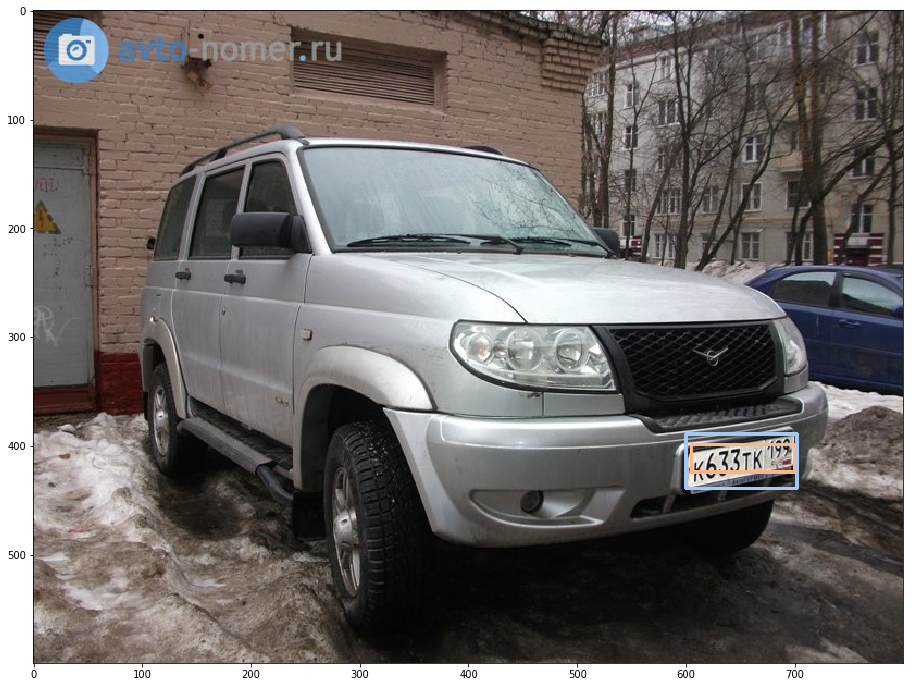

In [26]:
show_sample(val_predictions[662], preproc_val[662], 0.5)

Зафиксируем порог = 0.6, т.к. при нём фактически были корректно предсказаны все необходимые боксы

In [27]:
def make_ocr_dataset(predictions, dataset, score_threshold=0.6, jaccard_threshold=0.25):
    assert len(predictions) == len(dataset)
    records = []
    for pred, expected in zip(predictions, dataset):
        fname = expected['file']
        texts = expected['texts']
        expected_boxes = expected['boxes']
        record = dict(file=fname, boxes=[], texts=[], scores=[], is_correct=[])
        filtered_pairs = [(box, score) for (box, score)
                          in zip(pred['boxes'], pred['scores'])
                          if score >= score_threshold]
        if len(filtered_pairs) == 0:
            print(f'WARN: could\'n find any boxes for image {fname}')
            continue
        pred_boxes, scores = zip(*filtered_pairs)
        for pred_box, score in zip(pred_boxes, scores):
            for expected_box, text in zip(expected_boxes, texts):
                iou = get_iou(pred_box, expected_box)
                if iou >= jaccard_threshold:
                    record['boxes'].append(pred_box)
                    record['texts'].append(text)
                    record['scores'].append(float(score))
                    record['is_correct'].append(1)
                    break
            else: # Если не вышли по break, то бокс некорректен
                record['boxes'].append(pred_box)
                record['texts'].append('')
                record['scores'].append(float(score))
                record['is_correct'].append(0)
        records.append(record)
    return records

In [28]:
def print_precision(ocr_dataset):
    micro_precision = np.mean([corr for rec in ocr_dataset for corr in rec['is_correct']])
    macro_precision = np.mean([np.mean(rec['is_correct']) for rec in ocr_dataset])
    print(f'Precision micro: {micro_precision}\tPrecision macro: {macro_precision}')

In [29]:
val_ocr_data = make_ocr_dataset(val_predictions, preproc_val)

In [30]:
print_precision(val_ocr_data)

Precision micro: 0.9365895458440445	Precision macro: 0.9664166666666666


Примерно 6.3% обнаруженных номеров - ошибки. Если будем подмешивать сгенерированные данные, можно портить их с такой же частотой

In [31]:
pos_scores = [score for item in val_ocr_data
              for (score, is_correct) in zip(item['scores'], item['is_correct'])
              if is_correct]
neg_scores = [score for item in val_ocr_data
              for (score, is_correct) in zip(item['scores'], item['is_correct'])
              if not is_correct]
np.mean(pos_scores), np.mean(neg_scores)

(0.9934303378797079, 0.8131436053160075)

In [32]:
with open(val_pred_boxes_file, 'w') as f:
     json.dump(val_ocr_data, f)

# Получаем предсказания детектора на трейне

In [33]:
train_files = [item['file'] for item in preproc_train]

In [34]:
train_predictions = predict_boxes(model, train_files)

  4%|▍         | 1078/24632 [02:23<46:29,  8.44it/s]  

WARN: could'n find any boxes for image ../data/train/1123.jpg


 14%|█▎        | 3384/24632 [07:24<51:42,  6.85it/s]  

WARN: could'n find any boxes for image ../data/train/3531.bmp


 19%|█▉        | 4634/24632 [10:08<44:45,  7.45it/s]  

WARN: could'n find any boxes for image ../data/train/4820.bmp


 60%|█████▉    | 14752/24632 [32:34<21:02,  7.83it/s]  

WARN: could'n find any boxes for image ../data/train/15340.bmp


 86%|████████▌ | 21169/24632 [46:47<07:23,  7.81it/s]

WARN: could'n find any boxes for image ../data/train/22027.bmp


100%|██████████| 24632/24632 [54:29<00:00,  8.01it/s]


In [35]:
train_ocr_data = make_ocr_dataset(train_predictions, preproc_train)

WARN: could'n find any boxes for image train/1123.jpg
WARN: could'n find any boxes for image train/3531.bmp
WARN: could'n find any boxes for image train/3844.bmp
WARN: could'n find any boxes for image train/4820.bmp
WARN: could'n find any boxes for image train/10304.bmp
WARN: could'n find any boxes for image train/14862.bmp
WARN: could'n find any boxes for image train/15340.bmp
WARN: could'n find any boxes for image train/18619.bmp
WARN: could'n find any boxes for image train/20119.bmp
WARN: could'n find any boxes for image train/22027.bmp
WARN: could'n find any boxes for image train/22140.jpg


In [36]:
print_precision(train_ocr_data)

Precision micro: 0.9386144402221572	Precision macro: 0.9681916907943472


In [37]:
pd.DataFrame.from_records(train_ocr_data).tail(5)

,boxes,file,is_correct,scores,texts
24616,"[[495, 597, 785, 659]]",train/25627.jpg,[1],[0.9991903901100159],[A136CB154]
24617,"[[201, 657, 444, 723]]",train/25628.jpg,[1],[0.9991928935050964],[T252TO150]
24618,"[[204, 159, 289, 189]]",train/25629.bmp,[1],[0.9986831545829773],[B240PB35]
24619,"[[622, 378, 801, 432]]",train/25630.jpg,[1],[0.999454915523529],[K607AP199]
24620,"[[378, 197, 451, 216]]",train/25631.bmp,[1],[0.9930538535118103],[T454HK35]


In [38]:
with open(train_pred_boxes_file, 'w') as f:
     json.dump(train_ocr_data, f)

# Получаем предсказания детектора на тесте

In [39]:
test_img_paths = glob.glob(os.path.join(data_path, 'test/*'))
test_img_names = [path[len(data_path):] for path in test_img_paths]
test_img_names[0]

'test/0.jpg'

In [40]:
test_predictions = predict_boxes(model, test_img_names)

  3%|▎         | 101/3188 [00:13<07:08,  7.21it/s]

WARN: could'n find any boxes for image ../data/test/1087.bmp


 52%|█████▏    | 1671/3188 [03:46<03:00,  8.42it/s]

WARN: could'n find any boxes for image ../data/test/250.jpg


100%|██████████| 3188/3188 [07:11<00:00,  8.85it/s]


File: ../data/test/1313.bmp


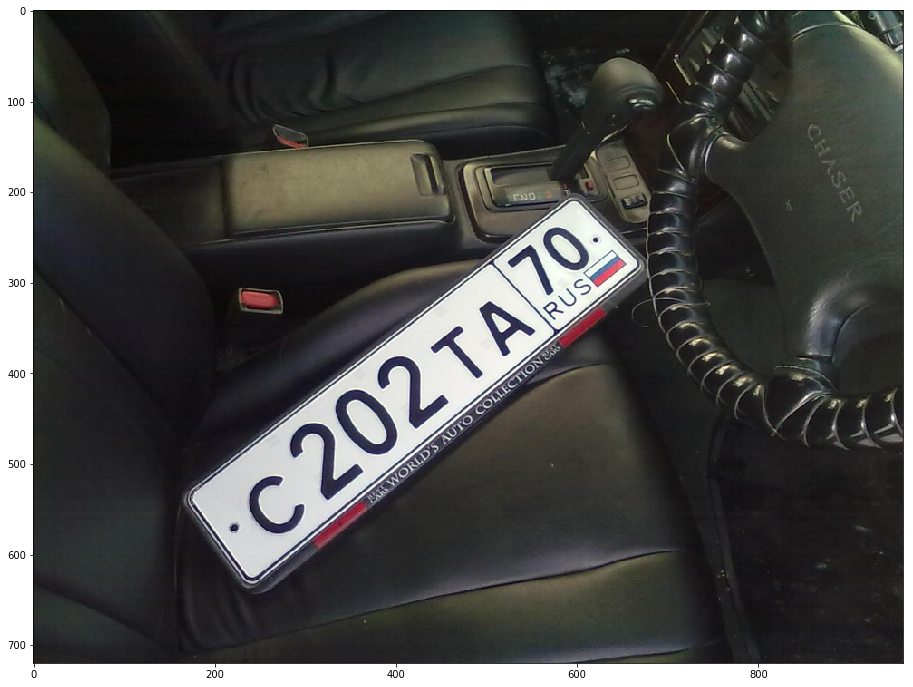

In [45]:
show_sample(test_predictions[351], None, 0.5)

In [48]:
def make_ocr_test_dataset(predictions, score_threshold=0.6):
    records = []
    for pred in predictions:
        fname = pred['file']
        boxes = pred['boxes']
        scores = [float(score) for score in pred['scores']]
        filtered_pairs = [(box, score) for (box, score)
                  in zip(boxes, scores)
                  if score >= score_threshold]
        if len(filtered_pairs) == 0:
            print(f'WARN: could\'n find any boxes for image {fname}')
            continue
        pred_boxes, scores = zip(*filtered_pairs)
        record = dict(file=fname, boxes=pred_boxes, scores=scores)
        records.append(record)
    return records

In [49]:
test_ocr_data = make_ocr_test_dataset(test_predictions)

WARN: could'n find any boxes for image test/1087.bmp
WARN: could'n find any boxes for image test/1313.bmp
WARN: could'n find any boxes for image test/2237.jpg
WARN: could'n find any boxes for image test/244.bmp
WARN: could'n find any boxes for image test/250.jpg


In [50]:
with open(test_pred_boxes_file, 'w') as f:
     json.dump(test_ocr_data, f)